<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader
import random
import os
sns.set(style="darkgrid", font_scale=1.4)

In [2]:
def seed_everywhere(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everywhere(42)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [3]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

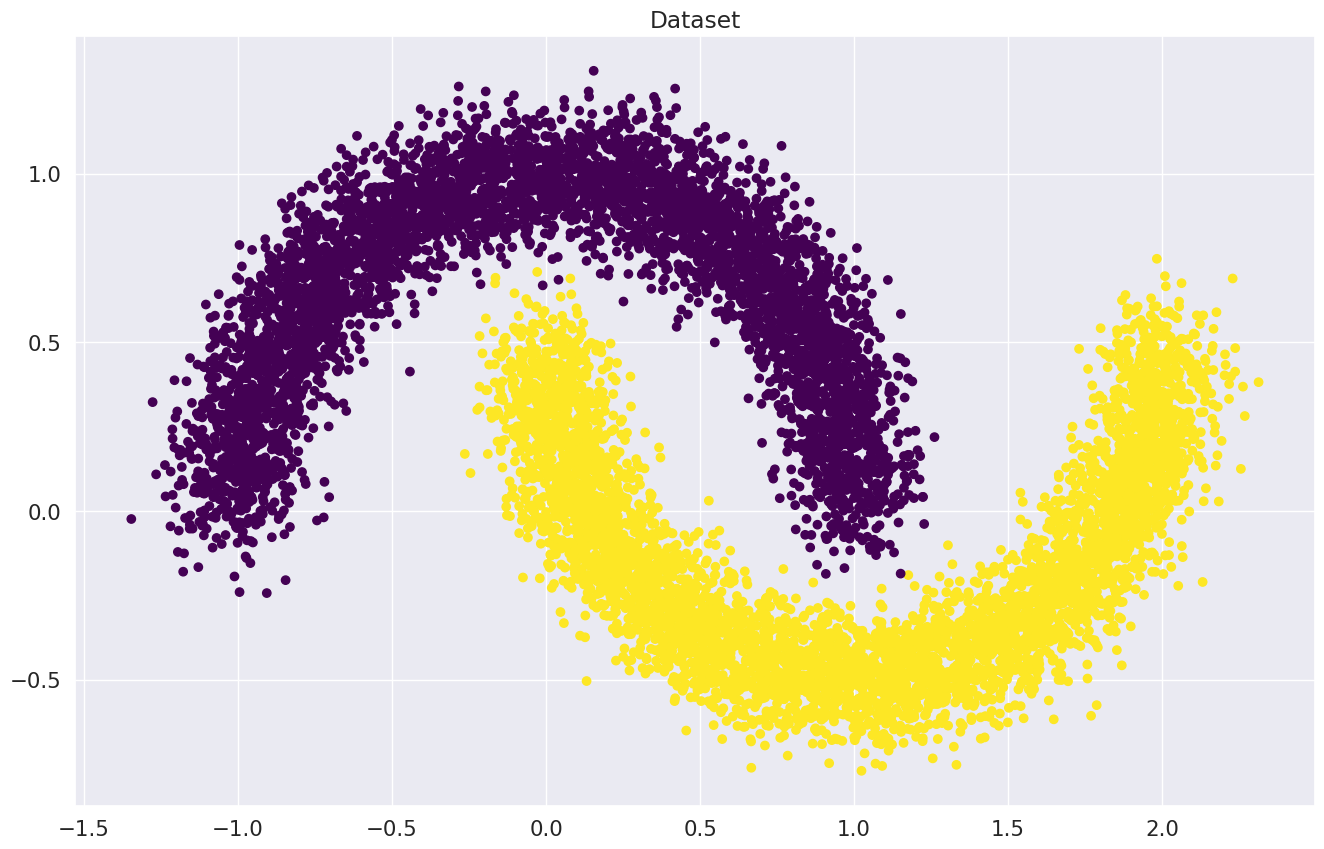

In [4]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [6]:
X_train_t =  torch.FloatTensor(X_train)
y_train_t =  torch.FloatTensor(y_train)
X_val_t =  torch.FloatTensor(X_val)
y_val_t =  torch.FloatTensor(y_val)

In [7]:
# Проверка
X_train_t.dtype

torch.float32

Создаем `Dataset` и `DataLoader`. 

In [8]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [9]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features, requires_grad=True))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(1, out_features, requires_grad=True))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [10]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [11]:
#YOUR CODE
print(f"Количество параметров: {2 * 1 + 1}  Веса(матрица 2 x 1) + bias(вектор 1 x 1)")

Количество параметров: 3  Веса(матрица 2 x 1) + bias(вектор 1 x 1)


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [12]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch) # YOUR CODE. Use linear_regression to get outputs
        loss = loss_function(outp, y_batch[:, None]) # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = F.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration: 0
Batch accuracy: 0.5625
Iteration: 100
Batch accuracy: 0.796875
Iteration: 200
Batch accuracy: 0.8125
Iteration: 300
Batch accuracy: 0.8984375
Iteration: 400
Batch accuracy: 0.875
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.828125

Iteration: 755.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ: 755**

### Визуализируем результаты

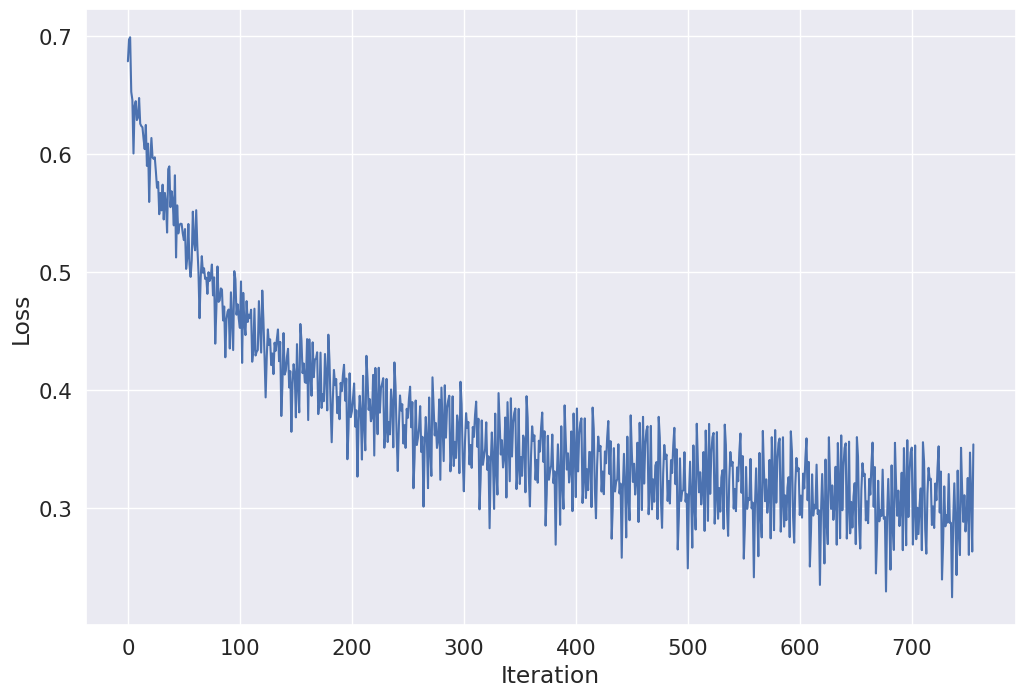

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

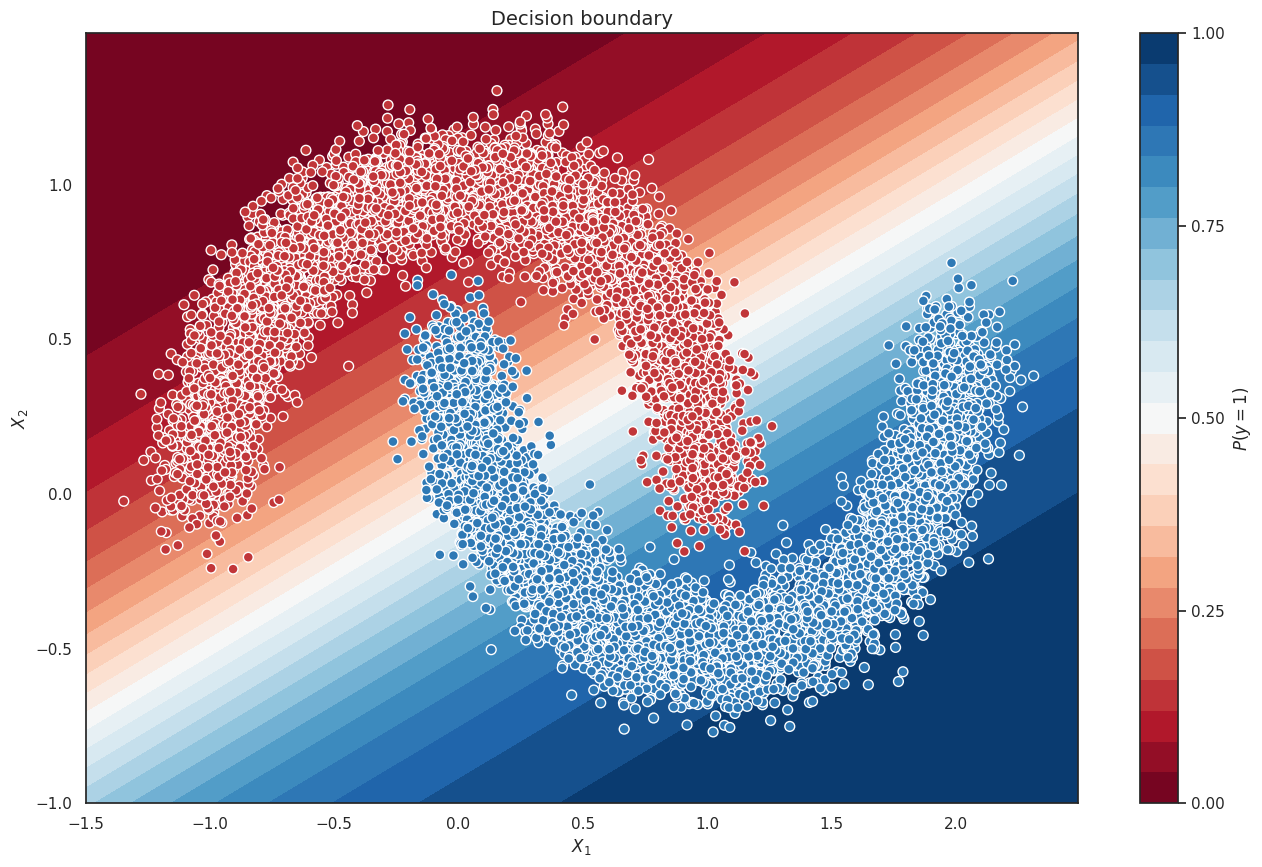

In [14]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [15]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = model(x_batch) #YOUR CODE. Compute predictions
        preds = F.sigmoid(preds)
        preds = (preds > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
# YOUR CODE. Compute total accuracy
with torch.no_grad():
    print(accuracy_score(y_val, predict(val_dataloader, linear_regression)))

0.862


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ: 0.862** 

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [33]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valid_dataloader =  DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [34]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [35]:
train_dataset.train_data[0].shape

/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([28, 28])

In [36]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    # Скрытые слои
    nn.Linear(in_features=28*28, out_features=128),
    nn.ELU(),
    nn.Linear(in_features=128, out_features=128),
    nn.ELU(),
    # Выходной слой
    nn.Linear(in_features=128, out_features=10),
    #YOUR CODE. Add layers to your sequential class
)

In [37]:
criterion = nn.CrossEntropyLoss()#YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [39]:
from tqdm.notebook import tqdm

In [40]:
model = model.to(device)

In [41]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in tqdm(range(max_epochs)):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in tqdm(dataloader):
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch.to(device)).to("cpu")
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch.to(device)).to("cpu")
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()# YOUR CODE GOES HERE
            all = y_batch.shape[0] # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.91055


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.956


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.9578166666666666


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9607


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.9675333333333334


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9571


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.9736333333333334


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9656


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.9761333333333333


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9739


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.9796666666666667


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9747


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.9816333333333334


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9755


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.9829


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9777


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.9849333333333333


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9697


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.9846


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9723


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [42]:
elu_accuracy = accuracy["valid"]

In [43]:
elu_accuracy

[0.956, 0.9607, 0.9571, 0.9656, 0.9739, 0.9747, 0.9755, 0.9777, 0.9697, 0.9723]

In [53]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    print(f"activation: {activation.__name__}")
    # model
    model = nn.Sequential(
        nn.Flatten(),
        # Скрытые слои
        nn.Linear(in_features=28*28, out_features=128),
        activation(),
        nn.Linear(in_features=128, out_features=128),
        activation(),
        # Выходной слой
        nn.Linear(in_features=128, out_features=10),
        #YOUR CODE. Add layers to your sequential class
    )
    criterion = nn.CrossEntropyLoss()#YOUR CODE. Select a loss function
    optimizer = torch.optim.Adam(model.parameters())
    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in tqdm(range(max_epochs)):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in tqdm(dataloader):
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch.to(device)).to("cpu")
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                    # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch.to(device)).to("cpu")
                    # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()# YOUR CODE GOES HERE
                all = y_batch.shape[0] # YOUR CODE GOES HERE
                epoch_correct += correct.item()
                epoch_all += all
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]

In [54]:
plain_accuracy = test_activation_function(Identical)

activation: Identical


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8708833333333333


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.8679


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.89445


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.912


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.9011833333333333


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9088


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.9040666666666667


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9135


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.9058333333333334


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.902


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.9076


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9031


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.9100666666666667


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.908


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.9112166666666667


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9174


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.91265


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9118


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.9137833333333333


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.914


In [56]:
relu_accuracy = test_activation_function(nn.ReLU)

activation: ReLU


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.89815


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.931


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.9498666666666666


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.96


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.9619666666666666


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9646


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.9681166666666666


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9635


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.9732666666666666


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9605


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.97565


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9705


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.9778666666666667


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9723


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.98075


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9744


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.9815833333333334


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9717


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.9829166666666667


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9675


In [57]:
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

activation: LeakyReLU


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.89905


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9507


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.9518166666666666


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9629


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.9622333333333334


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.964


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.9684833333333334


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9702


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.9727666666666667


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9664


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.9763166666666667


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9697


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.9762166666666666


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9628


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.9798333333333333


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9624


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.9819


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9693


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.9818166666666667


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.972


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

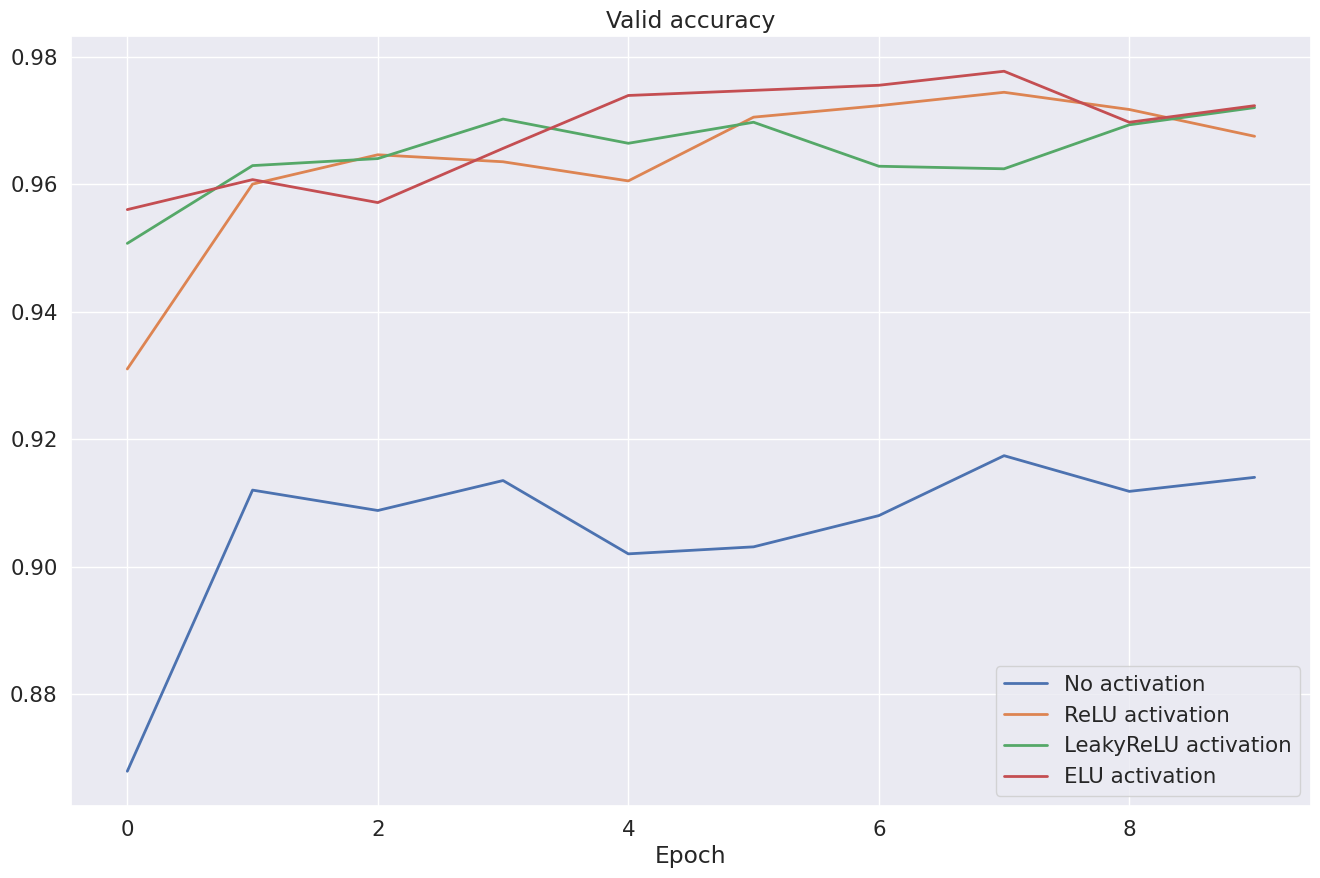

In [58]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

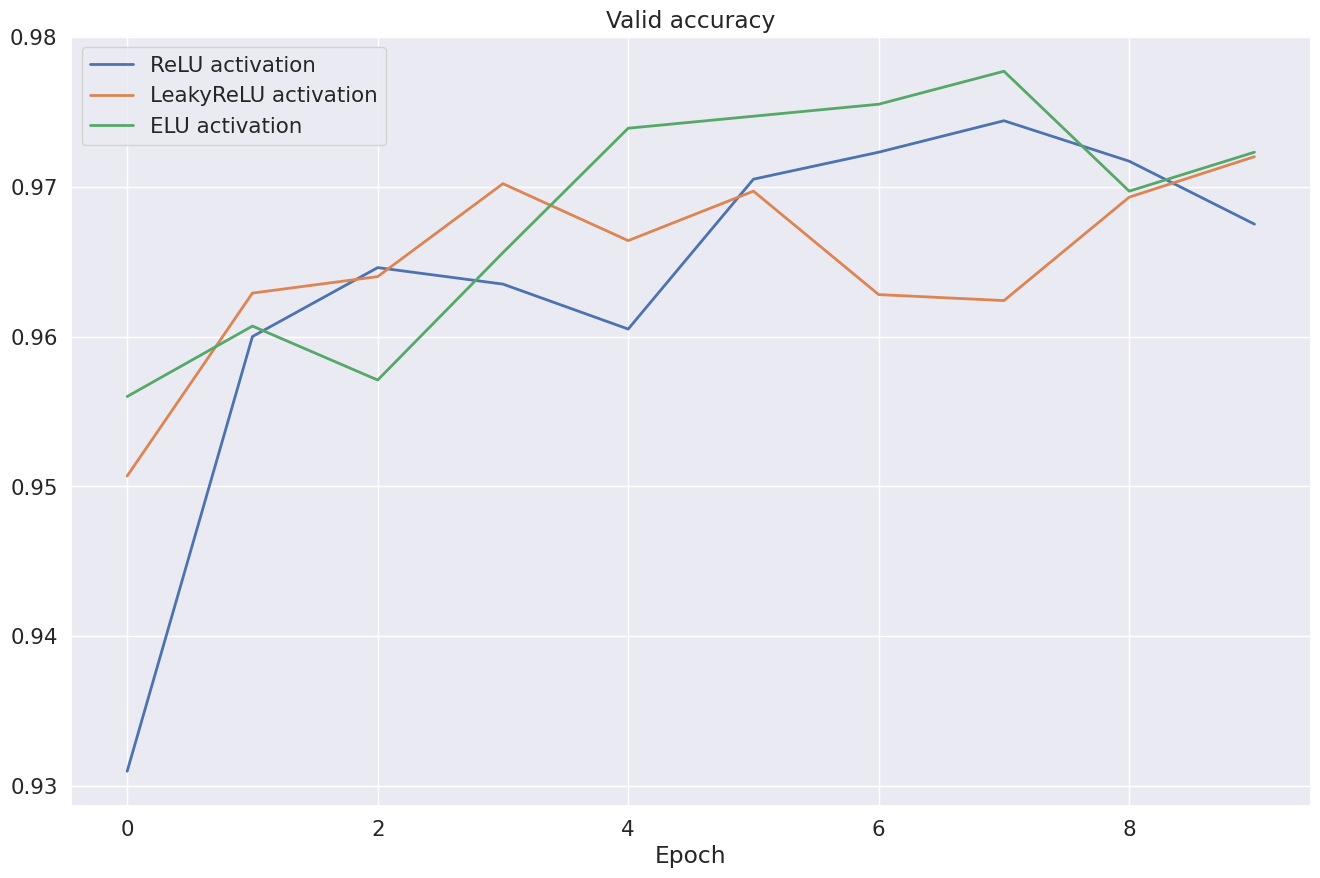

In [59]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ: ELU**

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [60]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-04-02 20:31:25--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2023-04-02 20:31:26--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 172.67.128.246, 104.21.1.92, 2606:4700:3030::6815:15c, ...
Connecting to img.the-village-kz.com (img.the-village-kz.com)|172.67.128.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.001s  

2023-04-02 20:31:27 

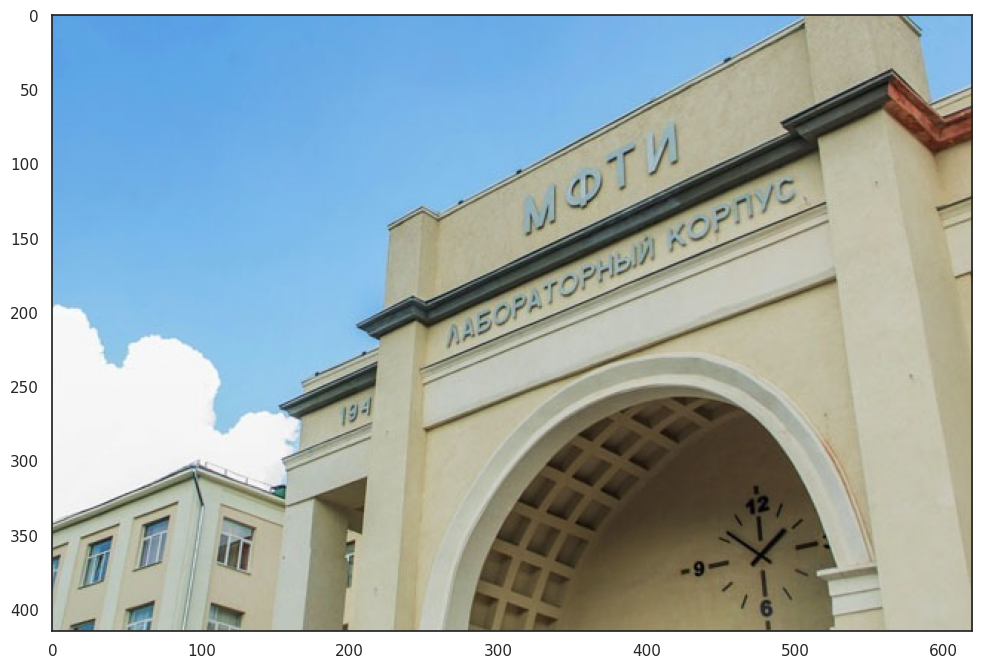

In [61]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [64]:
kernels = {
    "А": [[0, 0, 0],
          [0, 1, 0],
          [0, 0, 0]],
    "Б": [[0, 1, 0],
          [0, -2, 0],
          [0, 1, 0]],
    "В": [[0, 0, 0],
          [1, -2, 1],
          [0, 0, 0]],
    "Г": [[0, 1, 0],
          [1, -4, 1],
          [0, 1, 0]],
    "Д": [[0, -1, 0],
          [-1, 5, -1],
          [0, -1, 0]],
    "E": [[0.0625, 0.125, 0.0625],
          [0.125, 0.25, 0.125],
          [0.0625, 0.125, 0.0625]]
}

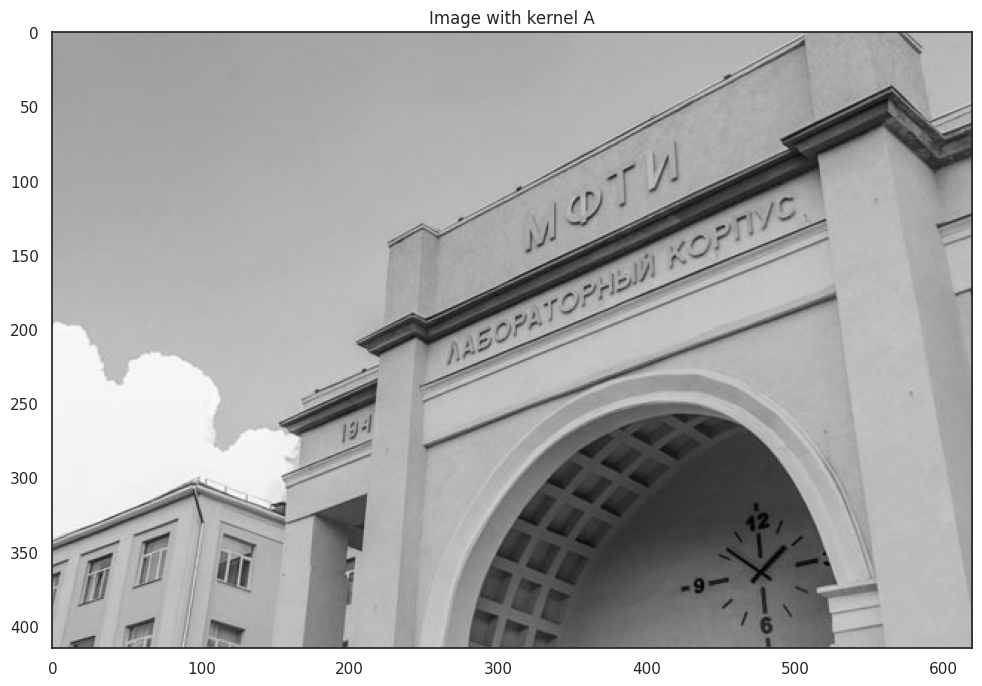

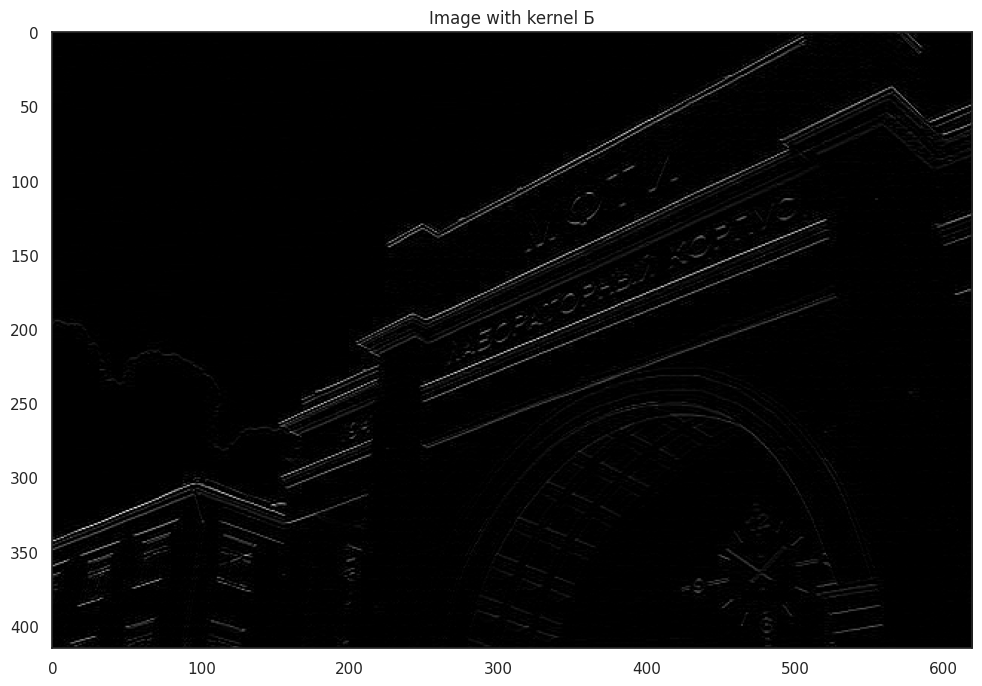

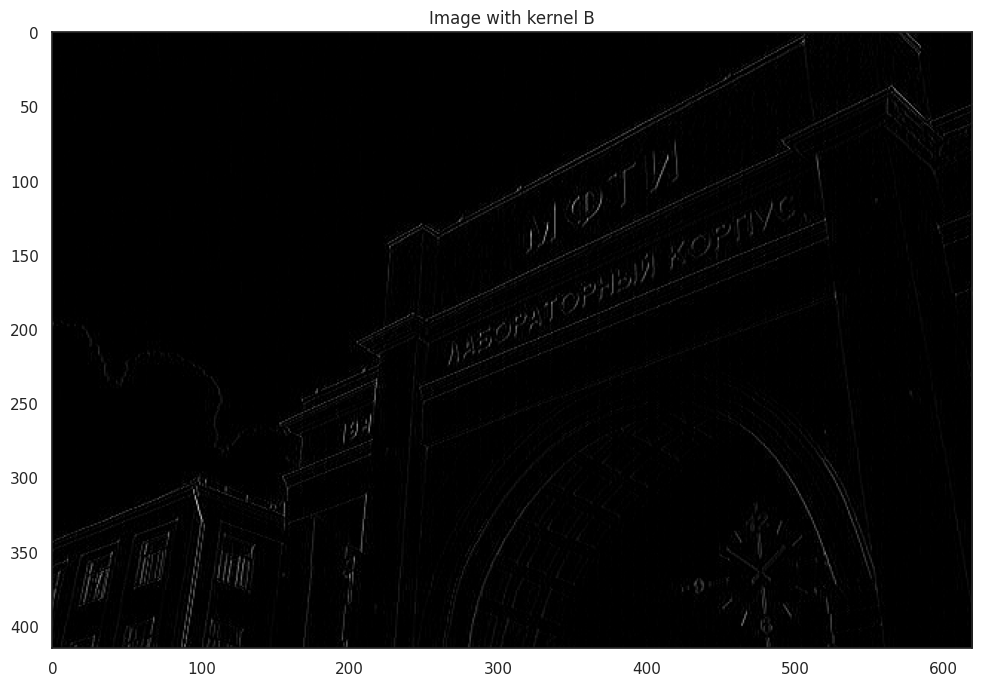

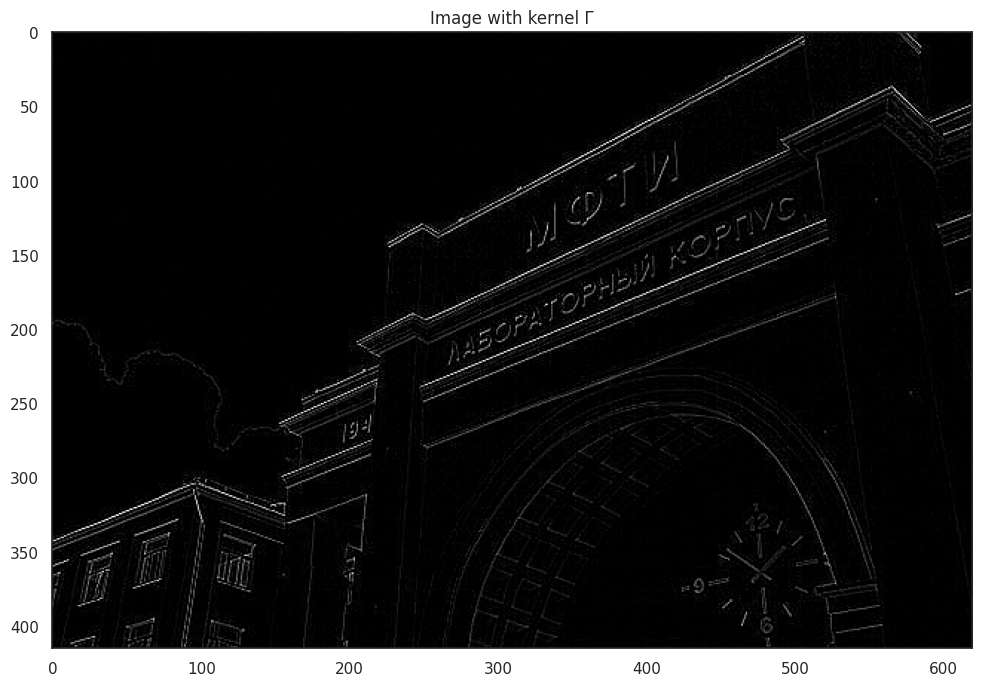

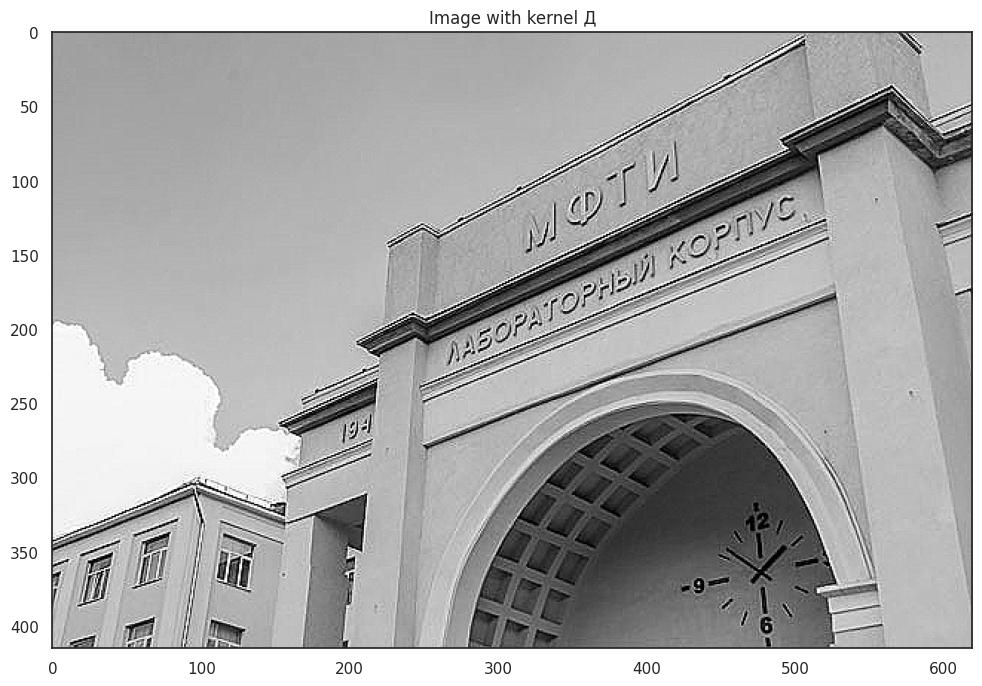

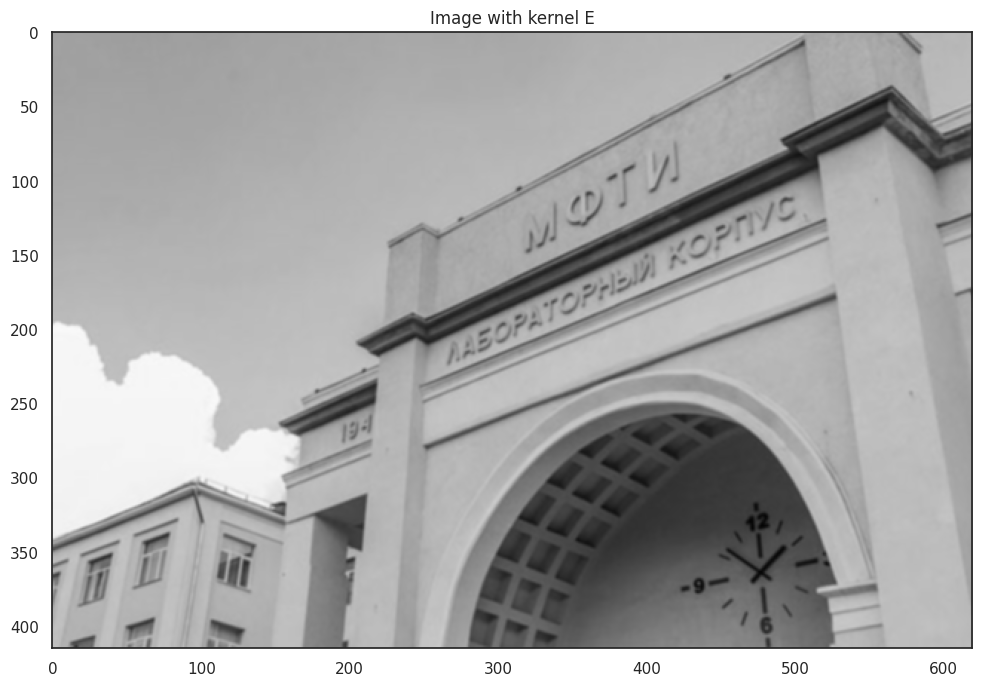

In [68]:
for name, kernel in kernels.items():
    img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
    kernel = torch.tensor(kernel).reshape(1, 1, 3, 3).type(torch.float32)
    kernel = kernel.repeat(3, 3, 1, 1)
    img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
    img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

    result = F.conv2d(img_t, kernel)[0]  #

    #plot
    plt.figure(figsize=(12, 8))
    result_np = result.permute(1, 2, 0).numpy() / 256 / 3
    plt.imshow(result_np)
    plt.title(f"Image with kernel {name}")
    plt.show()




**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ: 1) Е 2) Д 3) А 4) В 5) Б 6) Г**

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [97]:
x = torch.randn(32, 1, 28, 28)
print(x.shape)
x = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)(x)
print(x.shape)
x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
print(x.shape)
x = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)(x)
print(x.shape)
x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
print(x.shape)
x = nn.Flatten()(x)
print(x.shape)
x = nn.Linear(16*5*5, 120)(x)
print(x.shape)
x = nn.Linear(120, 84)(x)
print(x.shape)
x = nn.Linear(84, 10)(x)
print(x.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32, 6, 26, 26])
torch.Size([32, 6, 13, 13])
torch.Size([32, 16, 11, 11])
torch.Size([32, 16, 5, 5])
torch.Size([32, 400])
torch.Size([32, 120])
torch.Size([32, 84])
torch.Size([32, 10])


In [98]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # -> (BS, 16, 5, 5)
        self.fc1 = nn.Linear(16*5*5, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = nn.Flatten()(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [99]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [100]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in tqdm(range(max_epochs)):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in tqdm(dataloader):
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch.to(device)).to("cpu")
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch.to(device)).to("cpu")
                # YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = F.softmax(outp, dim=1).argmax(-1)
            #print(preds)
            #print(y_batch)
            correct = (preds == y_batch).sum()# YOUR CODE GOES HERE
            all = y_batch.shape[0] # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.9299833333333334


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9766


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 2
Loader: train. Accuracy: 0.9789166666666667


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9842


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 3
Loader: train. Accuracy: 0.9844166666666667


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9869


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 4
Loader: train. Accuracy: 0.9877833333333333


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.986


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 5
Loader: train. Accuracy: 0.9906166666666667


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9872


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 6
Loader: train. Accuracy: 0.9918666666666667


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9873


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 7
Loader: train. Accuracy: 0.99315


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9895


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 8
Loader: train. Accuracy: 0.9940333333333333


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9884


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 9
Loader: train. Accuracy: 0.9949333333333333


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.9877


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 10
Loader: train. Accuracy: 0.9957166666666667


  0%|          | 0/313 [00:00<?, ?it/s]

Loader: valid. Accuracy: 0.99


In [101]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

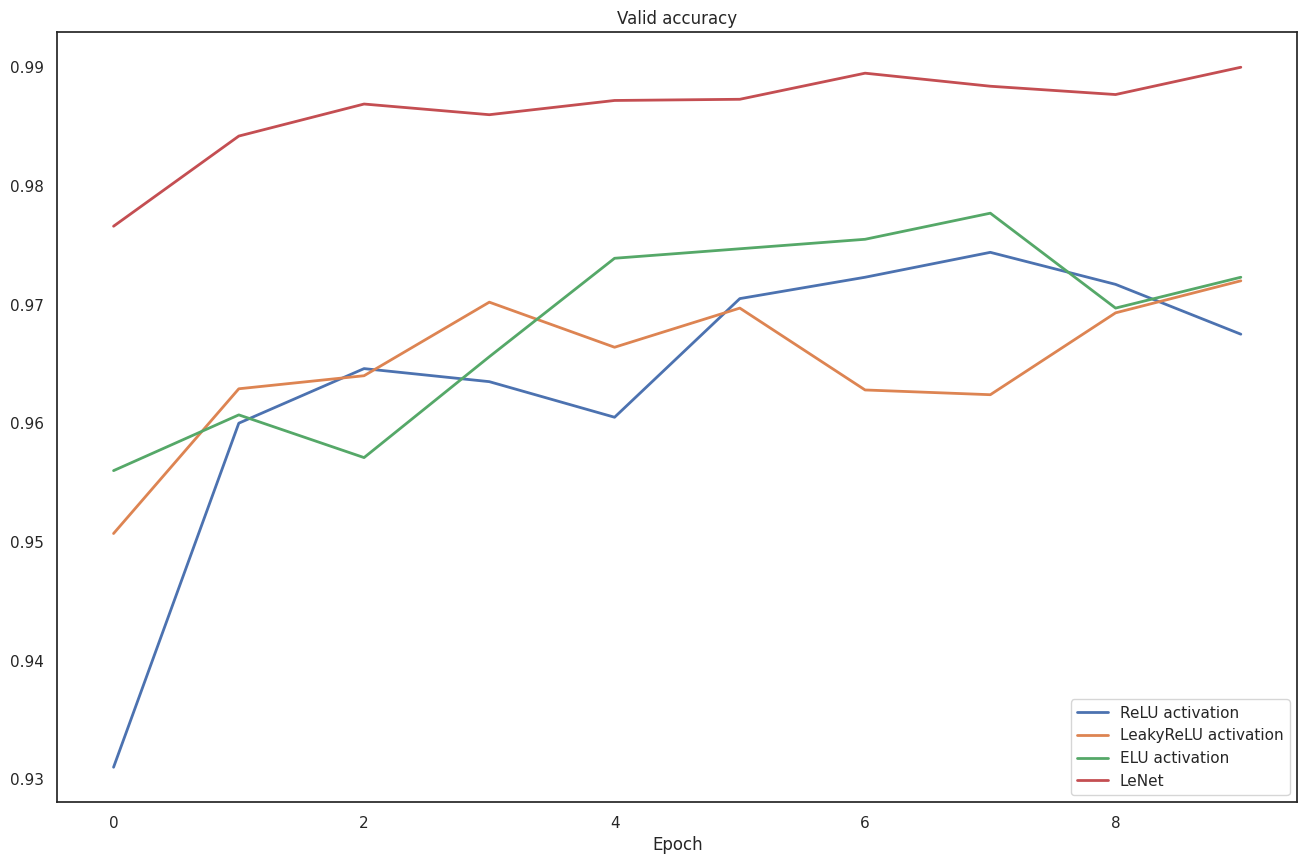

In [102]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [103]:
print(lenet_accuracy[-1])

0.99


**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ: 0.99**